# COS30049 Assignment 2 - Group 8



### Importing required python packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Help Functions

1. This help funtion will extract the deatures from the email body such as number of character, number of special characters and word count.

In [2]:
def add_features(df):
    susp_words = ['free','win','urgent','bank','prize','verify','account','gift']
    df = df.copy()
    df['num_chars'] = df['Body'].str.len()
    df['num_special_chars'] = df['Body'].str.count(r'[!@#$%^&*(),.?":{}|<>]')
    df['word_count'] = df['Body'].str.split().apply(len)
    df['has_susp'] = df['Body'].apply(lambda x: int(any(w in x for w in susp_words)))
    df['num_links'] = df['Body'].str.count(r"http")

    return df[['num_chars', 'num_special_chars', 'word_count', 'has_susp', 'num_links']]

## Data Processing

### Loading the datasets

1. Load the first dataset into a dataframe (from a csv) that has been downloaded from Kaggle, this dataset contains spam and ham email messages

In [3]:
# Load the dataset into a dataframe
email_df = pd.read_csv('datasets/completeSpamAssassin.csv', index_col=0)

email_df['Body'] = email_df['Body'].str.replace(r'\n', ' ', regex=True)

2. Load the second dataset into a new dataframe, this dataset contains spam and ham SMS messages.

In [4]:
# Loading the second dataset into a new dataframe
sms_df = pd.read_csv('datasets/spam.csv', encoding='latin-1')
print(len(sms_df))

5572


3. The SMS dataframe contains weird column names, time to change these column names so they are the same as the first dataframe.

In [5]:
# Keep only the columns we need and rename them to match the first dataframe
sms_df = sms_df[['v1', 'v2']]
sms_df = sms_df.rename(columns={'v1': 'Label', 'v2': 'Body'})

4. The email dataframe contains the values of 1 and 0 in the 'Label' column, we want to now change this to be 'spam' and 'ham' so that it matches the SMS dataframe.

In [6]:

# Map 'spam' to 1 and 'ham' to 0
email_df['Label'] = email_df['Label'].map({1: 'spam', 0: 'ham'})

4. The two dataframes will now be joined together to form one large dataframe.

In [7]:
# Join the two dataframes into a single dataframe using concat
df = pd.concat([email_df, sms_df], ignore_index=True)


5. The fifth step of cleaning and processing the data is to remove missing values. After evaluating the documentation provided with the spam email dataset we learned that 9% of entries into this dataset contain the word 'empty' in the 'Body' column. So for this step we will remove rows with missing values and rows with 'Empty' in the body.

In [8]:
# Removal of the rows with 'empty' in the 'Body' column
df = df[df['Body'] != 'empty']

# Remove rows with missing values
df = df.dropna()

2. This code returns a new dataframe only containing the extracted features, and not whether or not it's spam. For the purpose of further data analysis on these features I will add the label to this dataframe.

## Data Analysis

### Feature extraction for analysis

The first step of analysis is to create a new dataframe containing the extracted features about the data that we can use for analysis. The features we have extracted to use are as follows:
* Number of characters in the email body (num_chars)
* Number of special characters in the email body (num_special_chars)
* Word count of the email body (word_count)
* Presence of suspicious words in the email body (has_susp)
* Number of links in the email body (num_links) 

In [9]:
df_features = add_features(df) # Create a new dataframe with the extracted features
df_features['Label'] = df['Label'].values # Add the 'Label' column to the features dataframe for analysis

### Using the extracted features for analysis

#### Number of characters

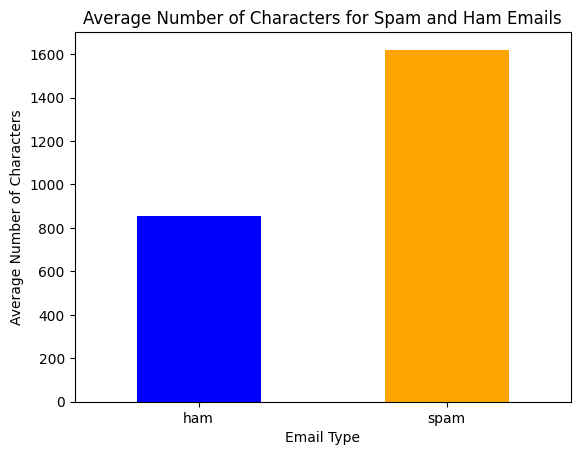

In [10]:
# Calculate the average number of characters for spam and ham emails
avg_chars = df_features.groupby('Label')['num_chars'].mean()

# Plot the bar chart
avg_chars.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Number of Characters for Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Average Number of Characters')
plt.xticks(rotation=0)
plt.show()

#### Number of special characters

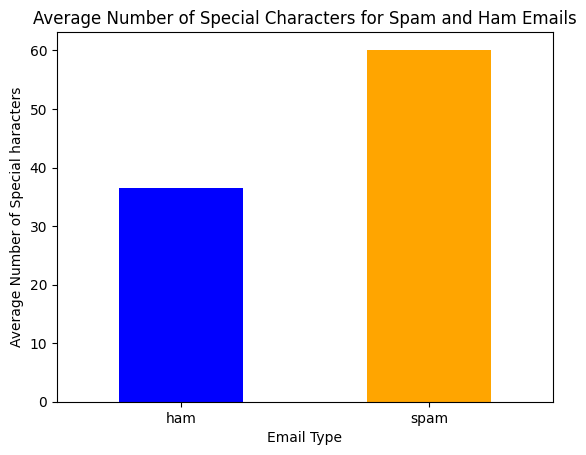

In [11]:
avg_special_chars = df_features.groupby('Label')['num_special_chars'].mean()
avg_special_chars.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Number of Special Characters for Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Average Number of Special haracters')
plt.xticks(rotation=0)
plt.show()

#### Word Count

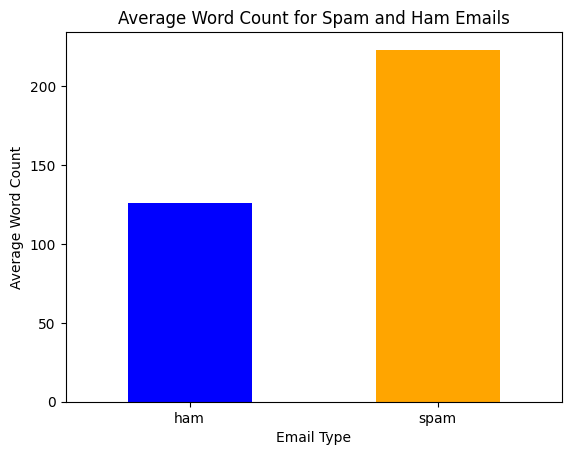

In [12]:
avg_words = df_features.groupby('Label')['word_count'].mean()
avg_words.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Word Count for Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.show()

#### Has Suspicious Words

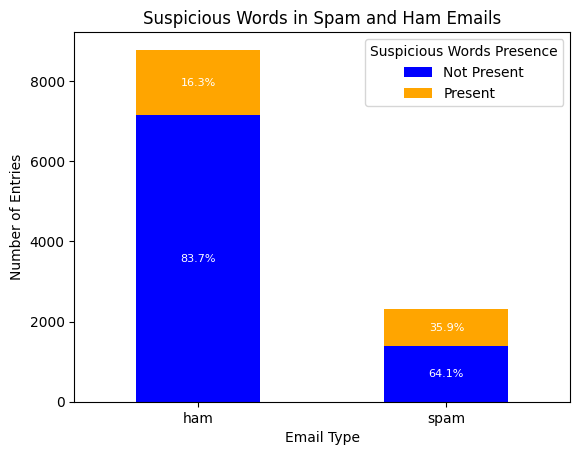

In [13]:
grouped_data = df_features.groupby(['Label', 'has_susp']).size().unstack()
grouped_data.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Suspicious Words in Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Number of Entries')
plt.xticks(rotation=0)
plt.legend(title='Suspicious Words Presence', labels=['Not Present', 'Present'])

percentages = grouped_data.div(grouped_data.sum(axis=0), axis=1) * 100

for i, bar_group in enumerate(plt.gca().containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:  # Only annotate non-zero bars
            plt.gca().text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{percentages.iloc[i, bar_group.index(bar)]:.1f}%',
                ha='center',
                va='center',
                fontsize=8,
                color='white'
            )
plt.show()

#### Number of Links

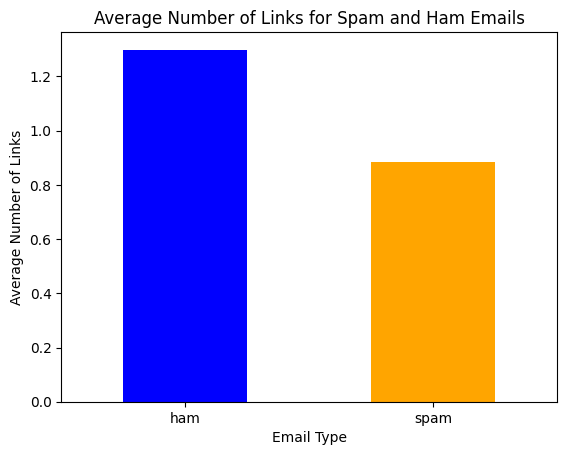

In [14]:
avg_links = df_features.groupby('Label')['num_links'].mean()
avg_links.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Number of Links for Spam and Ham Emails')
plt.xlabel('Email Type')
plt.ylabel('Average Number of Links')
plt.xticks(rotation=0)
plt.show()

### Bar chart to visualise the number of spam and ham messages in the dataset

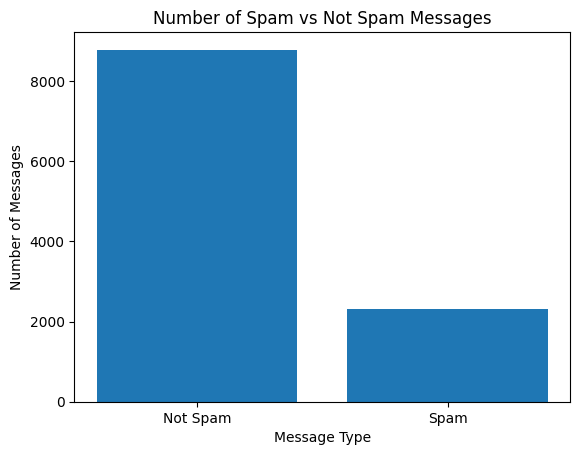

In [15]:
occurence_counts = df['Label'].value_counts()
plt.bar(occurence_counts.index, occurence_counts.values)
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.xlabel('Message Type')
plt.ylabel('Number of Messages')
plt.title('Number of Spam vs Not Spam Messages')
plt.show()

## Model Training

### Classification

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df[['Body']], df['Label'], test_size=0.2, random_state=42)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Body'),  # text features
        ('num', Pipeline([
            ('features', FunctionTransformer(add_features, validate=False)),
            ('scaler', StandardScaler())
        ]), ['Body'])  # numeric features extracted from 'Body'
    ]
)

In [18]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [19]:
# --- Train ---
clf.fit(X_train, y_train)

# --- Evaluate ---
print("Training Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

Training Accuracy: 0.974512236382091
Test Accuracy: 0.968425800631484


### Model Evaluation: Confustion Matrix

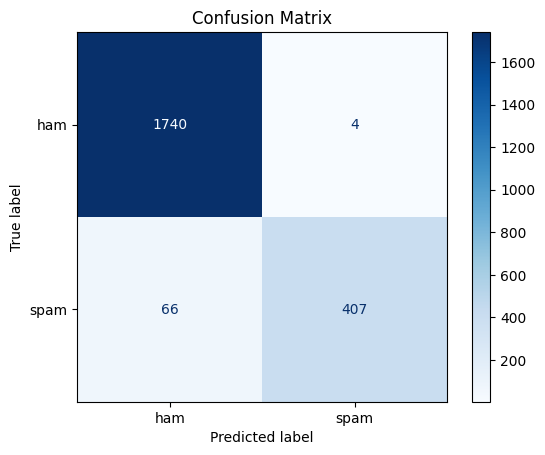

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Predictions
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [21]:
# kmeans = Pipeline([
#     ('preprocessor', preprocessor),
#     ('clusterer', KMeans(n_clusters=2, random_state=42, n_init=10))
# ])

# kmeans.fit(df[['Body']])

# df['cluster'] = kmeans['clusterer'].labels_

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Body'])

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

df['Cluster'] = clusters
print(df[['Body','Label','Cluster']])

                                                    Body Label  Cluster
0      \r Save up to 70% on Life Insurance.\r Why Spe...  spam        0
1      1) Fight The Risk of Cancer!\r http://www.adcl...  spam        1
2      1) Fight The Risk of Cancer!\r http://www.adcl...  spam        0
3      ##############################################...  spam        0
4      I thought you might like these:\r 1) Slim Down...  spam        1
...                                                  ...   ...      ...
11613  This is the 2nd time we have tried 2 contact u...  spam        0
11614              Will Ì_ b going to esplanade fr home?   ham        0
11615  Pity, * was in mood for that. So...any other s...   ham        0
11616  The guy did some bitching but I acted like i'd...   ham        0
11617                         Rofl. Its true to its name   ham        0

[11084 rows x 3 columns]


In [22]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# True labels
y_true = df['Label']

# Cluster assignments
y_pred = df['Cluster']

# Convert labels to numeric for comparison
y_true_num = y_true.map({'ham':0, 'spam':1})

# --- Evaluation metrics ---
ari = adjusted_rand_score(y_true_num, y_pred)
nmi = normalized_mutual_info_score(y_true_num, y_pred)

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")


Adjusted Rand Index (ARI): -0.061
Normalized Mutual Information (NMI): 0.017


### Model: Random Forest Classifier

In [ ]:
#  Feature Extraction Function 
# will flag if message contains suspicious words common in spam such as 'free', 'win', etc. 
def add_features(df):
    susp_words = ['free','win','urgent','bank','prize','verify','account','gift']
    df = df.copy()
    df['num_chars'] = df['Body'].str.len()
    df['num_special_chars'] = df['Body'].str.count(r'[!@#$%^&*(),.?":{}|<>]')
    df['word_count'] = df['Body'].str.split().apply(len)
    df['has_susp'] = df['Body'].apply(lambda x: int(any(w in x for w in susp_words)))
    df['num_links'] = df['Body'].str.count(r"http")
    return df[['num_chars', 'num_special_chars', 'word_count', 'has_susp', 'num_links']]


In [ ]:
#  Load Datasets and cleans text by removing newline and gives consistent structure

email_df = pd.read_csv('datasets/completeSpamAssassin.csv', index_col=0)
email_df['Body'] = email_df['Body'].str.replace(r'\n', ' ', regex=True)


# Concatenates both datasets to create one combined dataset 
sms_df = pd.read_csv('datasets/spam.csv', encoding='latin-1')[['v1', 'v2']]
sms_df = sms_df.rename(columns={'v1': 'Label', 'v2': 'Body'})

email_df['Label'] = email_df['Label'].map({1: 'spam', 0: 'ham'})
df = pd.concat([email_df, sms_df], ignore_index=True)
df = df[df['Body'] != 'empty'].dropna()

In [ ]:
#  Split Data 
X_train, X_test, y_train, y_test = train_test_split(df[['Body']], df['Label'], test_size=0.2, random_state=42)

#  Preprocessor (so model can see Text + Numeric Features simultaeneously) 
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Body'),
        ('num', Pipeline([
            ('features', FunctionTransformer(add_features, validate=False)),
            ('scaler', StandardScaler())
        ]), ['Body'])
    ]
)

#  Random Forest Classifier Pipeline to ensure preprocessing applies automatically during training and prediction
rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,       # number of trees
        max_depth=None,         # let trees expand until pure
        random_state=42,
        n_jobs=-1               # use all CPU cores
    ))
])

#  Train Model 
rf_clf.fit(X_train, y_train)

#  Evaluate Model 
print("Training Accuracy:", rf_clf.score(X_train, y_train))
print("Test Accuracy:", rf_clf.score(X_test, y_test))

# Predictions
y_pred = rf_clf.predict(X_test)

#  Classification Report 
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Training Accuracy: 1.0
Test Accuracy: 0.9702300405953992

Classification Report:

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1744
        spam       1.00      0.86      0.93       473

    accuracy                           0.97      2217
   macro avg       0.98      0.93      0.95      2217
weighted avg       0.97      0.97      0.97      2217



### Model Evaluation: Confusion Matrix

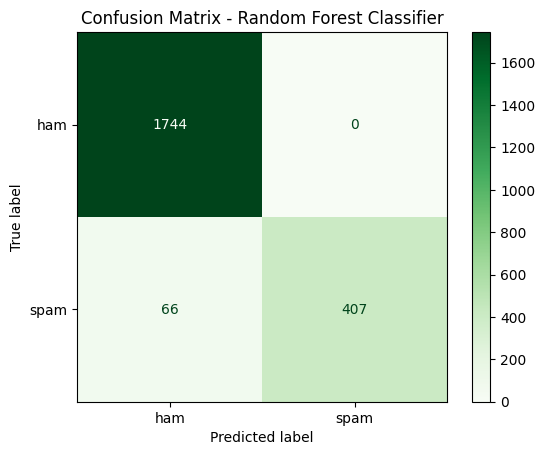

In [ ]:
#  Confusion Matrix 
cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()